In [1]:
import matplotlib.pyplot as plt
import backtrader as bt
import backtrader.analyzers as btanalyzers
from analyzers import InMarketAnalyzer, CashValueAnalyzer, SortinoRatio
from datetime import datetime

import pandas as pd
import numpy as np
from strategies import CCIStrategy


In [2]:
# Create a cerebro engine instance
cerebro = bt.Cerebro(cheat_on_open=True)
start_date = datetime(1993, 1, 29)
end_date = datetime(2024, 7, 24)
data = bt.feeds.YahooFinanceCSVData(dataname='Data/SPY.csv', fromdate=start_date, todate=end_date, adjclose=True, round=False)
cerebro.adddata(data)

# Add the WilliamsR strategy
cerebro.addstrategy(CCIStrategy, period=9, upperband=30, lowerband=-30.0)
cerebro.broker.setcommission(commission=0.0)
# cerebro.broker.set_coc(True)

# Set initial capital and broker settings
# This code was assited using Codeium autocomplete
start_cash = 100000.0000
cerebro.broker.setcash(start_cash)
cerebro.addsizer(bt.sizers.PercentSizer, percents=100)
cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name="trade_stats")
cerebro.addanalyzer(btanalyzers.DrawDown, _name="drawdown")
cerebro.addanalyzer(btanalyzers.Returns, _name="returns")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, 
                _name='sharpe',
                timeframe=bt.TimeFrame.Days,  # Timeframe to match hourly data
                compression=1,                  # Compression for hourly data (60 minutes)
                riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturn')
cerebro.addanalyzer(InMarketAnalyzer, _name="in_market")
cerebro.addanalyzer(CashValueAnalyzer, _name="cash_value")
cerebro.addanalyzer(SortinoRatio, _name='sortino')

# Print starting capital
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run the strategy
strat = cerebro.run()

# Print final capital
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
Final Portfolio Value: 982930.52


In [3]:
data_results = {}
returns_stats = strat[0].analyzers.returns.get_analysis()
trade_stats = strat[0].analyzers.trade_stats.get_analysis()
drawdown_stats = strat[0].analyzers.drawdown.get_analysis()
in_market_stats = strat[0].analyzers.in_market.get_analysis()

data_results["period"] = strat[0].params.period
data_results["lowerband"] = strat[0].params.lowerband
data_results["upperband"] = strat[0].params.upperband
data_results["total_return"] = returns_stats['rtot']
data_results["cagr"] = returns_stats['rnorm']
data_results["return_per_exposer"] = returns_stats['rnorm'] / (in_market_stats["Total In-Market Bars"] / in_market_stats["Total Bars"])
data_results["sharpe"] = strat[0].analyzers.sharpe.get_analysis()['sharperatio']
data_results["sortino"] = strat[0].analyzers.sortino.get_analysis()['Sortino Ratio']
data_results["total_trades"] = trade_stats.total.closed
data_results["winning_trades"] = trade_stats.won.total
data_results["losing_trades"] = trade_stats.lost.total
data_results["time_in_market"] = in_market_stats["Total In-Market Bars"] / in_market_stats["Total Bars"]
data_results["profit_factor"] = in_market_stats["Total Gains"] / in_market_stats["Total Losses"]
data_results["avg_gain"] = in_market_stats["Total Percent Gain"] / trade_stats.total.closed
data_results["max_drawdown"] = drawdown_stats.max.drawdown
data_results["max_drawdown_duration"] = drawdown_stats.max.len

data_results

{'period': 9,
 'lowerband': -30.0,
 'upperband': 30,
 'total_return': 2.285368251599315,
 'cagr': 0.07536615853497086,
 'return_per_exposer': 0.1988522545100463,
 'sharpe': 0.06161497371444121,
 'sortino': 0.05621360010179872,
 'total_trades': 574,
 'winning_trades': 408,
 'losing_trades': 166,
 'time_in_market': 0.3790058036840777,
 'profit_factor': 1.6176763497764581,
 'avg_gain': 1.5394442014697827,
 'max_drawdown': 49.079596553108544,
 'max_drawdown_duration': 1525}

In [6]:
print(f"Risk adjusted return: {(returns_stats['rnorm']) / (in_market_stats["Total In-Market Bars"] / in_market_stats["Total Bars"])*100:.2f}%")

Risk adjusted return: 19.89%


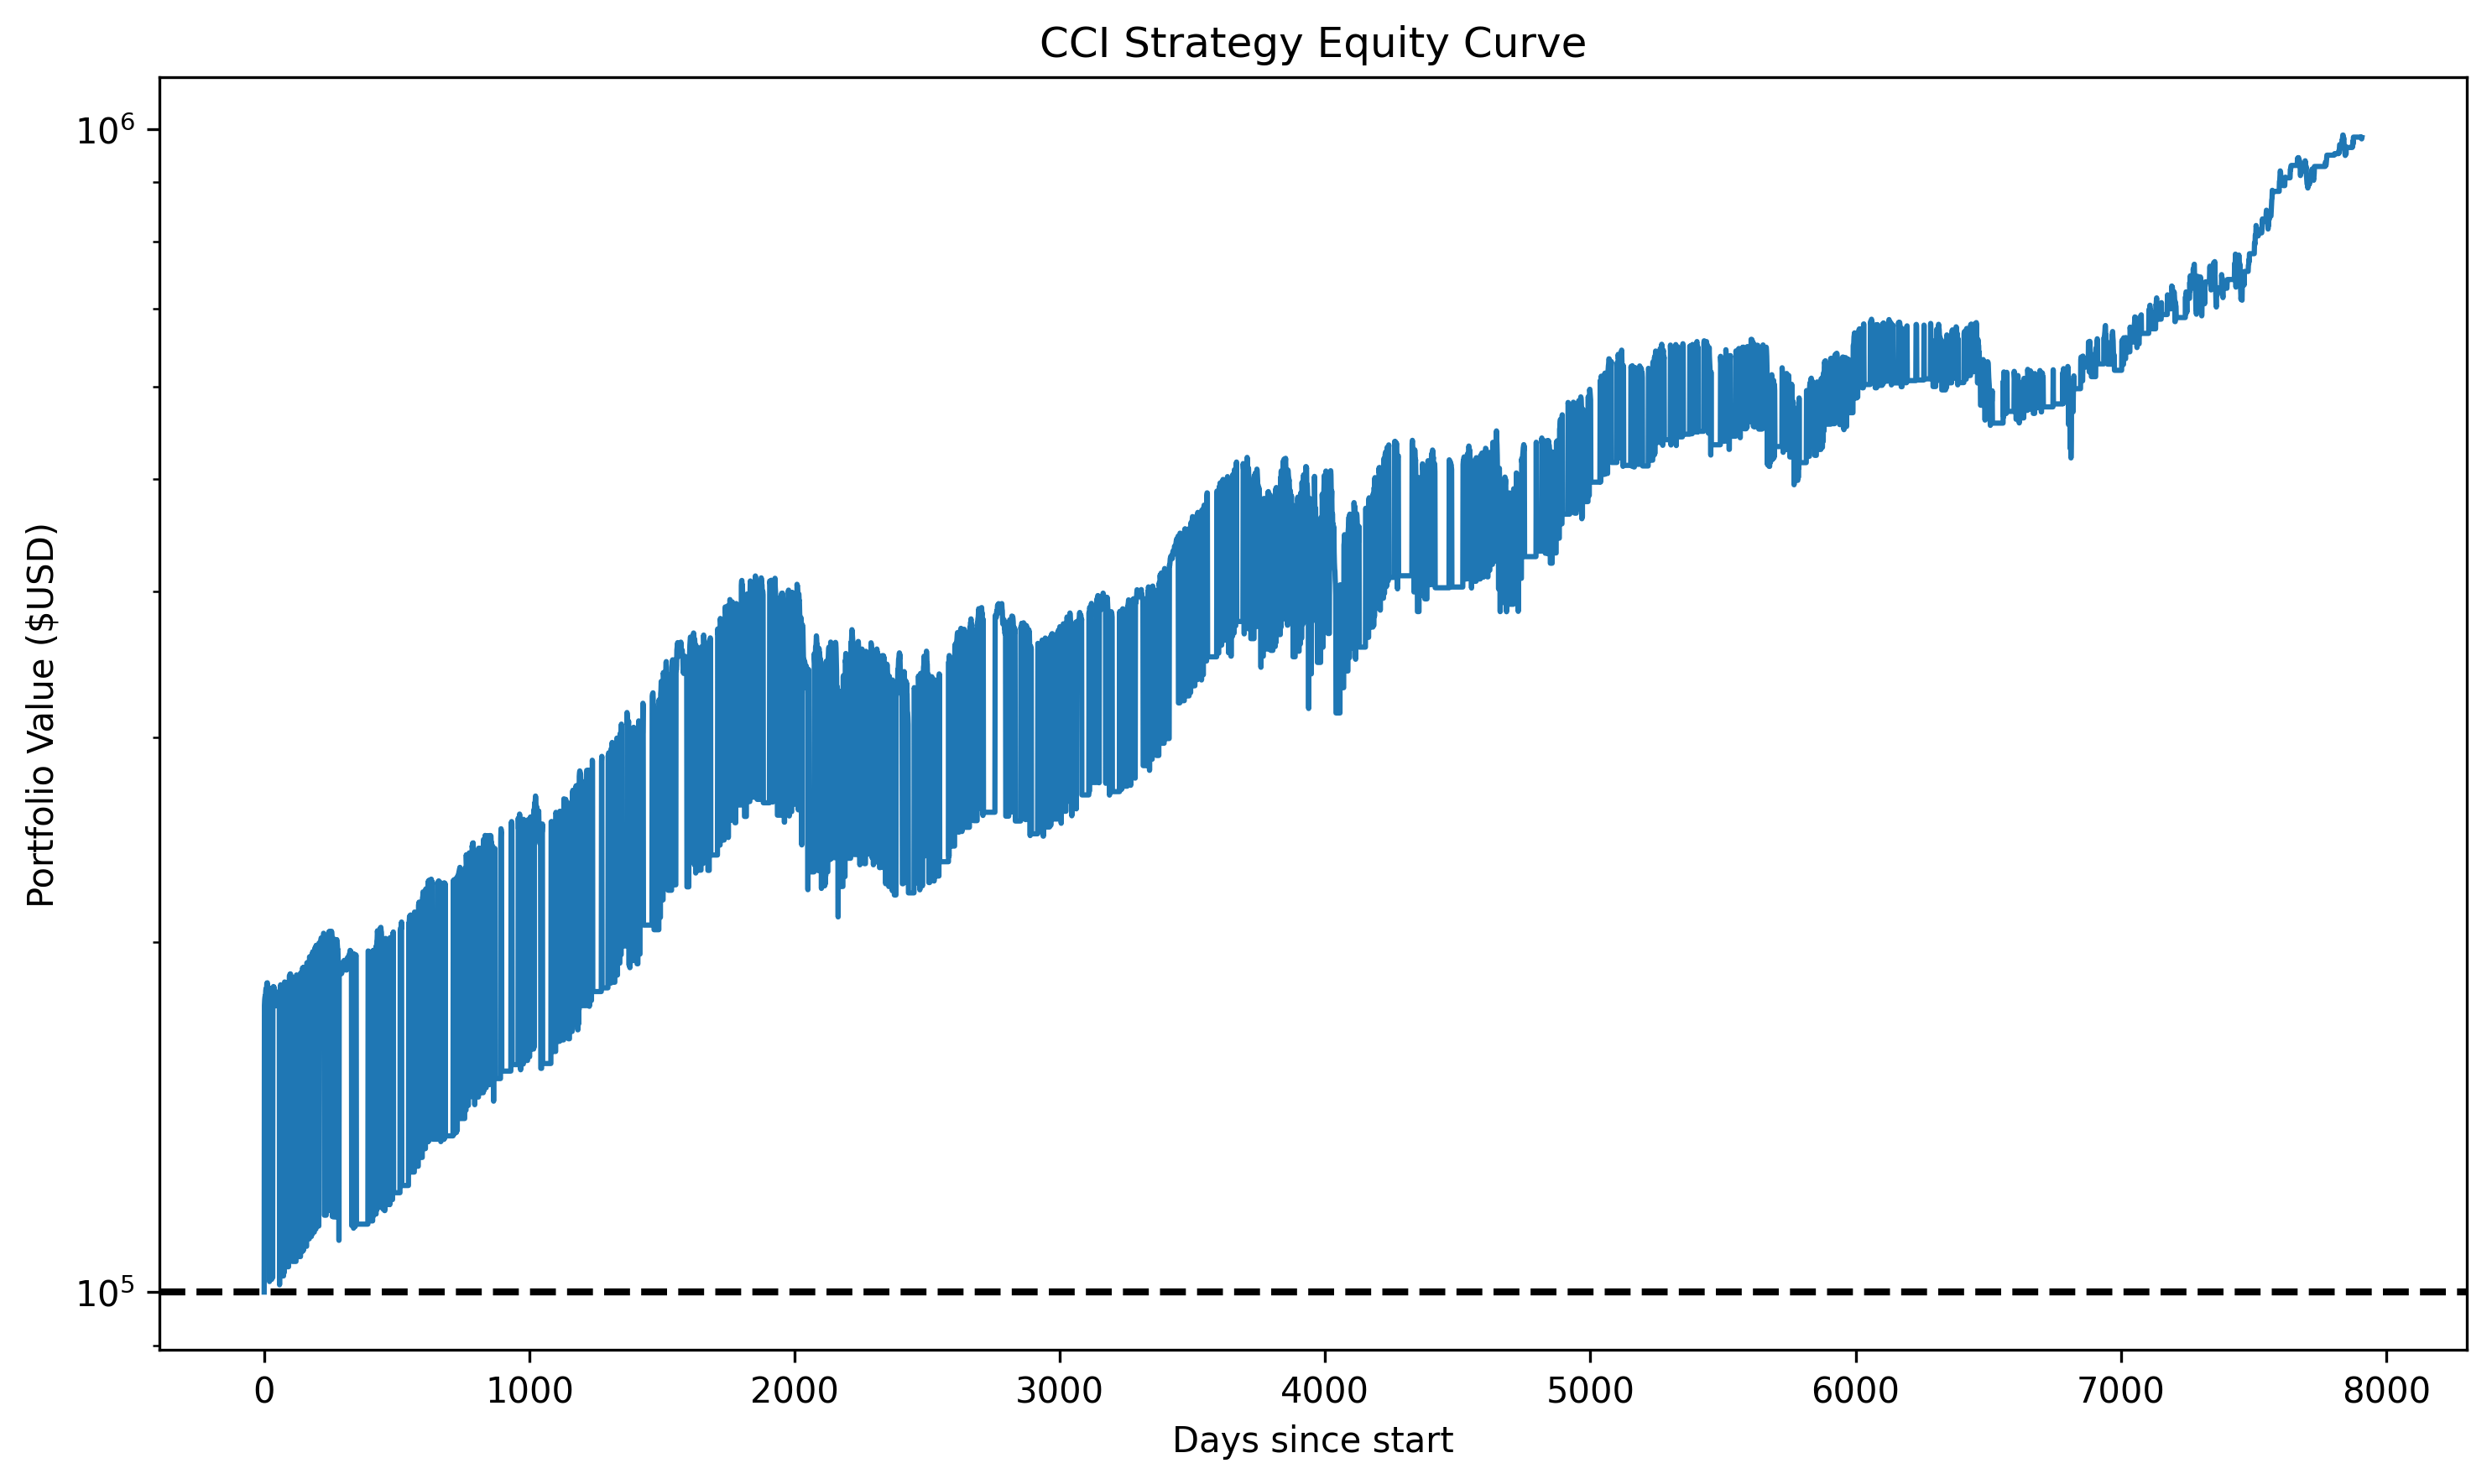

In [4]:
plt.figure(figsize=(10, 6), dpi=300)
plt.axhline(y=100000, color='black', linestyle='--', linewidth=2)

plt.plot(strat[0].equity_curve)
plt.title(f"CCI Strategy Equity Curve")
plt.xlabel('Days since start')
plt.ylabel('Portfolio Value ($USD)')

plt.yscale('log')
plt.tight_layout()